In [1]:
%%time
%run main_hpp.py --dataset CA --embedding_sizes 2 5 10 20

Building graph: 100%|██████████| 534477/534477 [00:14<00:00, 36911.92it/s]


[deepwalk] Evaluating embedding size: 2


DeepWalk Nodes: 100%|██████████| 20433/20433 [09:12<00:00, 36.97it/s] 


[deepwalk] Evaluating embedding size: 5


DeepWalk Nodes: 100%|██████████| 20433/20433 [09:13<00:00, 36.93it/s] 


[deepwalk] Evaluating embedding size: 10


DeepWalk Nodes: 100%|██████████| 20433/20433 [09:22<00:00, 36.34it/s] 


[deepwalk] Evaluating embedding size: 20


DeepWalk Nodes: 100%|██████████| 20433/20433 [09:31<00:00, 35.78it/s] 


[deepwalk] Best embedding size: 20 with rmse: 47232.022
[node2vec] Evaluating embedding size: 2


Node2Vec Walks: 100%|██████████| 80/80 [02:02<00:00,  1.53s/it]


[node2vec] Evaluating embedding size: 5


Node2Vec Walks: 100%|██████████| 80/80 [01:47<00:00,  1.34s/it]


[node2vec] Evaluating embedding size: 10


Node2Vec Walks: 100%|██████████| 80/80 [01:49<00:00,  1.36s/it]


[node2vec] Evaluating embedding size: 20


Node2Vec Walks: 100%|██████████| 80/80 [01:48<00:00,  1.36s/it]


[node2vec] Best embedding size: 10 with rmse: 47186.491
✅ Results saved to results/CA/final_results.xlsx
CPU times: total: 2h 49min 28s
Wall time: 1h 39min 24s


In [1]:
%%time
%run main_hpp.py --dataset MHD --embedding_sizes 2 5 10 20

Building graph: 100%|██████████| 1333688/1333688 [01:01<00:00, 21747.79it/s]


[deepwalk] Evaluating embedding size: 2


DeepWalk Nodes: 100%|██████████| 5000/5000 [08:19<00:00, 10.00it/s]


[deepwalk] Evaluating embedding size: 5


DeepWalk Nodes: 100%|██████████| 5000/5000 [08:23<00:00,  9.93it/s]


[deepwalk] Evaluating embedding size: 10


DeepWalk Nodes: 100%|██████████| 5000/5000 [08:28<00:00,  9.83it/s]


[deepwalk] Evaluating embedding size: 20


DeepWalk Nodes: 100%|██████████| 5000/5000 [08:47<00:00,  9.49it/s]


[deepwalk] Best embedding size: 5 with r2: 0.845
[node2vec] Evaluating embedding size: 2


Node2Vec Walks: 100%|██████████| 80/80 [09:15<00:00,  6.95s/it]


[node2vec] Evaluating embedding size: 5


Node2Vec Walks: 100%|██████████| 80/80 [11:26<00:00,  8.58s/it]


[node2vec] Evaluating embedding size: 10


Node2Vec Walks: 100%|██████████| 80/80 [09:08<00:00,  6.85s/it]


[node2vec] Evaluating embedding size: 20


Node2Vec Walks: 100%|██████████| 80/80 [11:19<00:00,  8.49s/it]


[node2vec] Best embedding size: 10 with r2: 0.851
✅ Results saved to results/MHD/final_results.xlsx
CPU times: total: 3h 15min 34s
Wall time: 1h 31min 35s


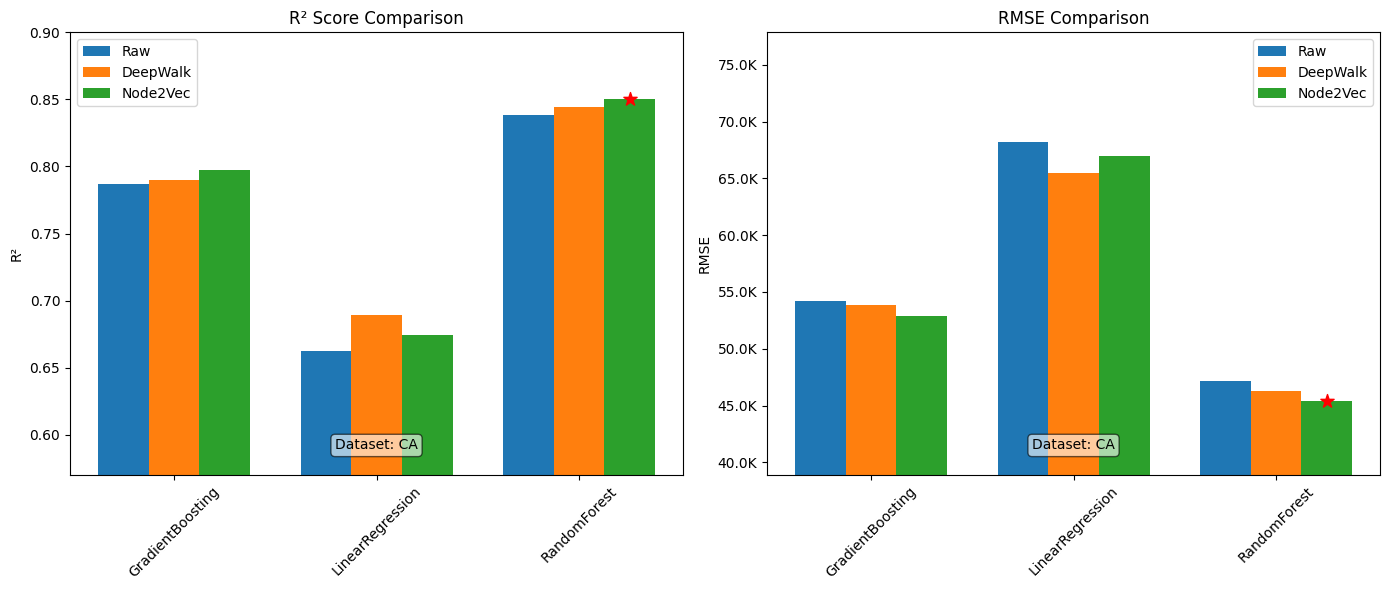

Comparison plot saved to results/CA/model_comparison_rmse.png


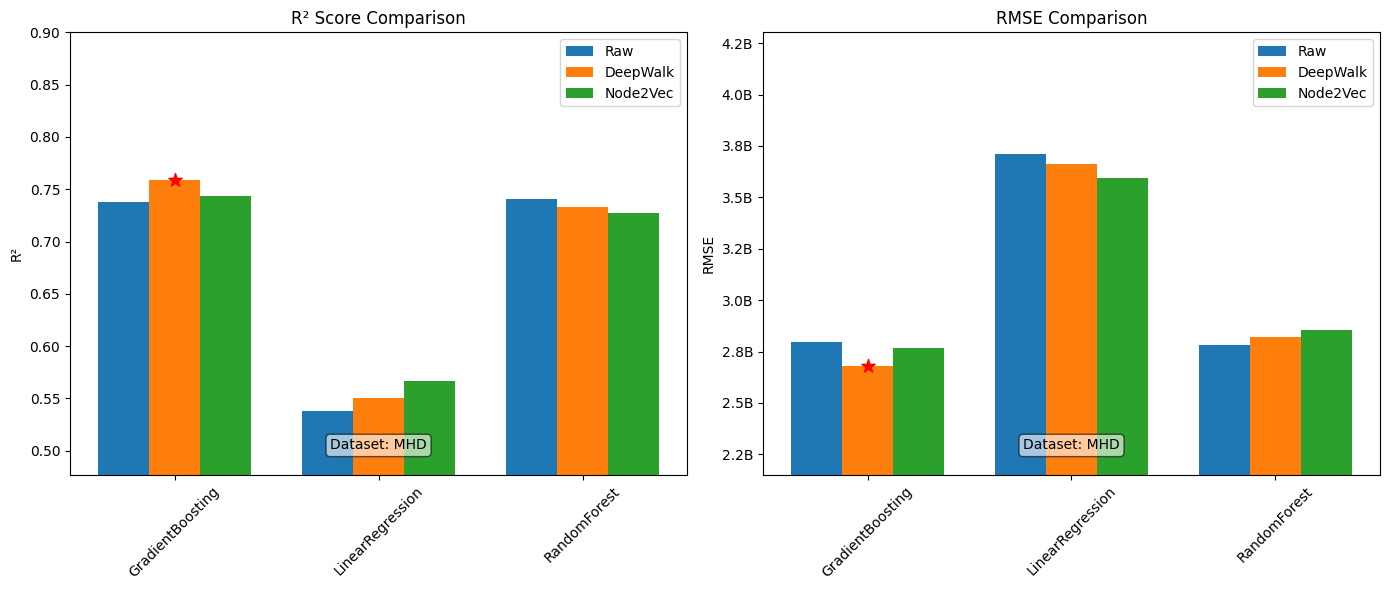

Comparison plot saved to results/MHD/model_comparison_rmse.png


In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FuncFormatter
import os

def compare_models(dataset_name, use_rmse=False):
    """
    Side-by-side comparison plots (R² and MSE_log or RMSE) for a dataset.
    - Highlights the single best model across all methods with a red star.
    - Adds dataset name to each subplot.
    - Applies y-axis limits to emphasize differences.
    - If use_rmse=True, plots RMSE in millions; otherwise plots MSE_log.
    """
    # Load results
    file_path = f"results/{dataset_name}/final_results.xlsx"
    df = pd.read_excel(file_path)

    # Categorize models
    def categorize(model):
        if "DeepWalk" in model:
            return "DeepWalk"
        elif "Node2Vec" in model:
            return "Node2Vec"
        else:
            return "Raw"

    df["Type"] = df["Model"].apply(categorize)
    df["BaseModel"] = df["Model"].apply(lambda x: x.split(" ")[0])

    # Pivot to align bars by BaseModel for each Type
    order_types = ["Raw", "DeepWalk", "Node2Vec"]
    r2_pivot = df.pivot_table(index="BaseModel", columns="Type", values="R2", aggfunc="mean").reindex(columns=order_types)
    mselog_pivot = df.pivot_table(index="BaseModel", columns="Type", values="MSE_log", aggfunc="mean").reindex(columns=order_types)
    rmse_pivot = df.pivot_table(index="BaseModel", columns="Type", values="RMSE", aggfunc="mean").reindex(columns=order_types)

    # Base models for x-axis
    models = r2_pivot.index.tolist()
    x = np.arange(len(models))
    bar_width = 0.25

    fig, axs = plt.subplots(1, 2, figsize=(14, 6))

    # -------------------------------
    # Plot 1: R² comparison
    # -------------------------------
    all_r2_bars = []
    bar_positions = []
    for i, t in enumerate(order_types):
        vals = r2_pivot[t].values
        positions = x + i*bar_width - bar_width
        axs[0].bar(positions, vals, width=bar_width, label=t)
        all_r2_bars.extend(vals)
        bar_positions.extend(positions)

    # Highlight single best R² (max)
    best_idx = np.nanargmax(all_r2_bars)
    axs[0].scatter(bar_positions[best_idx], all_r2_bars[best_idx],
                   color="red", zorder=5, s=100, marker="*")

    axs[0].set_title("R² Score Comparison")
    axs[0].set_xticks(x)
    axs[0].set_xticklabels(models, rotation=45)
    axs[0].set_ylabel("R²")
    axs[0].legend()

    # y-axis limit
    r2_mean = np.nanmean(all_r2_bars)
    axs[0].set_ylim(r2_mean - 0.2, 0.9)

    axs[0].text(0.5, 0.05, f"Dataset: {dataset_name}", transform=axs[0].transAxes,
                fontsize=10, ha="center", va="bottom",
                bbox=dict(boxstyle="round", fc="white", alpha=0.6))

    # -------------------------------
    # Plot 2: MSE_log or RMSE comparison
    # -------------------------------
    if use_rmse:
        metric_name = "RMSE"
        pivot = rmse_pivot
        # formatter
        def thousands(x, pos): return f"{x/1e3:.1f}K"
        def millions(x, pos): return f"{x/1e6:.1f}M"
        def billions(x, pos): return f"{x/1e9:.1f}B"

        if dataset_name == 'CA':
            axs[1].yaxis.set_major_formatter(FuncFormatter(thousands))
        else:
            axs[1].yaxis.set_major_formatter(FuncFormatter(billions))
    else:
        metric_name = "MSE (log-scale)"
        pivot = mselog_pivot

    all_metric_bars = []
    bar_positions_metric = []
    for i, t in enumerate(order_types):
        vals = pivot[t].values
        positions = x + i*bar_width - bar_width
        axs[1].bar(positions, vals, width=bar_width, label=t)
        all_metric_bars.extend(vals)
        bar_positions_metric.extend(positions)

    # Highlight single best (min) for RMSE or MSE_log
    best_idx = np.nanargmin(all_metric_bars)
    axs[1].scatter(bar_positions_metric[best_idx], all_metric_bars[best_idx],
                   color="red", zorder=5, s=100, marker="*")

    axs[1].set_title(f"{metric_name} Comparison")
    axs[1].set_xticks(x)
    axs[1].set_xticklabels(models, rotation=45)
    axs[1].set_ylabel(metric_name)
    axs[1].legend()

    # y-axis limit
    y_mean = np.nanmean(all_metric_bars)
    axs[1].set_ylim(y_mean * 0.7, y_mean * 1.4)

    axs[1].text(0.5, 0.05, f"Dataset: {dataset_name}", transform=axs[1].transAxes,
                fontsize=10, ha="center", va="bottom",
                bbox=dict(boxstyle="round", fc="white", alpha=0.6))

    plt.tight_layout()

    # Save figure
    out_path = f"results/{dataset_name}/model_comparison.png" if not use_rmse \
               else f"results/{dataset_name}/model_comparison_rmse.png"
    os.makedirs(f"results/{dataset_name}", exist_ok=True)
    plt.savefig(out_path, dpi=300)
    plt.show()
    print(f"Comparison plot saved to {out_path}")


# Example runs
# compare_models("CA")          # R² + MSE_log
# compare_models("MHD")         # R² + MSE_log
compare_models("CA", True)  # R² + RMSE (in millions)
compare_models("MHD", True)
